# Convolutional neural networks for genetic sequences

By Ziga Avsec

Now that you have learned the basics in the previous exercise, let's have a look at the real-world example. We are going to use a set sequences at the ChIP-seq peaks of the FoxA1 transcription factor.

## Install the dependencies

In [ ]:
!pip install concise

You can import and directly use the convenience functions from the previous example:

In [28]:
!wget https://raw.githubusercontent.com/Avsecz/DL-genomics-exercise/master/utils.py

--2018-06-27 23:15:37--  https://raw.githubusercontent.com/Avsecz/DL-genomics-exercise/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3200 (3,1K) [text/plain]
Saving to: ‘utils.py’

100%[======================================>] 3.200       --.-K/s   in 0s      

2018-06-27 23:15:38 (75,3 MB/s) - ‘utils.py’ saved [3200/3200]



In [20]:
from utils import evaluate, plot_filters, plot_history, plot_seq_importance

## Loading the deepbind data

The raw sequneces from the ChIP-seq peaks provided in the supplementary material of the article look like this:

```
FoldID	EventID	seq	Bound
A	seq_00001_peak	CTGAAATTGCTGTATTTACCTTGAAAACCACAAACTGTAAACAGGGCACCTGTTCAGAGAAGATCTTCAAACTGCTCACTCACTAAATCAACACCTGGGAA	1
A	seq_00003_peak	GAGGCACTGGGGCAGAACAAATTTGCACAGTGTCTGCTGTGGACATAAGGGATTTCTTCAGCCCTATGCAAATAGTAATCCCACTAGTTCCCAGAAGATAA	1
A	seq_00005_peak	CTTTTACTATTTACCTTGGCAAGTCCAGGACCGGATTGATGATCTGTAAAGTGGATTTGTTATTTGGCTGTTTGCTTTGGCAGCTCTTGAAAGCACTTTGC	1
A	seq_00007_peak	AAAACAGATGTTGCAACAAGCAAACATCTTTGTGATGACACAGTGATGTTATCGTAGCTGTATAAACAACCGTATGGCCTTTGGCCTGAGATTCCGGAAGC	1
A	seq_00009_peak	CAGTGTTTGCCCTTCCAAAGCCAGAGCCATAAAAGGCAGCTTTCAAAGTCACTGCCGCAGAAATGTCAACATGAGGGGGAGGCCAGTCATGGTTTCTGAGG	1
A	seq_00011_peak	GAGGCCCCATGCTCATTTTTTTCCTCTCCCAGAATCTCAGAAAAGTAAATAACCACCCGAGCTGCTCTAGCGGGTAAACAGCCCAGAGTTTGCTCTCCTAA	1
A	seq_00013_peak	GAGAATGGAGAGAAGCAGCTAGGCAAATAATTGGCAAGAAAAGTAAACAGTTACAGTGCAGCTTTGTTTACCCACTCTGCCTATCTGCGTTTCTGAAATTG	1
A	seq_00015_peak	TGGTTCCAAGTGTGTCAACAGCCTGTTGCTTTCTAGTTCAACAAGAGGGAATAATCTTTGGTAAACATGGCCGTTGGAAAAAAGCAAATATTTGTCTTGGC	1
A	seq_00017_peak	CCAGGAAGAAGAACGATAAAGCTTGTTGACTTTTGCTCTTTGGAGGCTATCTTTCTCCTAGCAGAGTAAACGCATCTCTAGGGGATTAAAGGCAGGCTCCA	1
```

We are providing you the code to download, load and pre-process data directly:

In [2]:
import pandas as pd
from concise.preprocessing import encodeDNA

def load_deepbind_data(path, shuffle=True):
    """Load the DeepBind data into
    
    Args:
      path: path to the .seq.gz file of deebbind.
        example: 'https://github.com/jisraeli/DeepBind/raw/master/data/encode/FOXA1_HepG2_FOXA1_(SC-101058)_HudsonAlpha_AC.seq.gz'
    
    Returns:
      (one-hot-encoded array, labels)
    """
    import random
    from random import Random
    def dincl_shuffle_string(s):
        sl = [s[2*i:2*(i+1)] for i in range(int(np.ceil(len(s)/2)))]
        random.shuffle(sl)
        return "".join(sl)
    
    # Load the positive sequences
    df = pd.read_table(path)
    df = df[df.Bound==1]
    pos_seq = list(df.seq)
    
    # Generate the negative set by permuting the sequence
    neg_seq = [dincl_shuffle_string(s) for s in pos_seq]
    seqs = pos_seq + neg_seq
    labels = [1] * len(pos_seq) + [0] * len(neg_seq)
    
    # Permute the order
    idx = list(range(len(seqs)))
    if shuffle:
        Random(42).shuffle(idx)
        
    return encodeDNA(seqs)[idx], np.array(labels)[idx]

In [3]:
x_train, y_train = load_deepbind_data('https://github.com/jisraeli/DeepBind/raw/master/data/encode/FOXA1_HepG2_FOXA1_(SC-101058)_HudsonAlpha_AC.seq.gz')

In [4]:
x_test, y_test = load_deepbind_data('https://github.com/jisraeli/DeepBind/raw/master/data/encode/FOXA1_HepG2_FOXA1_(SC-101058)_HudsonAlpha_B.seq.gz')

In [5]:
x_train[0][:10]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [6]:
y_train[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0])

## TODO

Your task is now to:
- train a model
- evaluate it
- visualize the filters
- visualize the importance scores
- lookup the discovered motif
  - Visit http://cisbp.ccbr.utoronto.ca/ and enter FoxA1 motif  
  - Lookup other motifs on: http://meme-suite.org/tools/tomtom

------------------------------------------------------

### Define the model

In [7]:
from keras.models import Sequential
import keras.layers as kl
from keras.callbacks import EarlyStopping, History

In [8]:
# Define model architecture
model = Sequential([kl.Conv1D(16, 15, activation='relu', input_shape=x_train.shape[1:]),
                    kl.GlobalMaxPooling1D(),
                    kl.Dense(1),
                    kl.Activation('sigmoid')
                   ])

In [9]:
# Compile the model. Optimize a classification loss function
model.compile("adam", "binary_crossentropy", ["accuracy"])

In [10]:
# Visualize model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 87, 16)            976       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [11]:
# Train the model
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.2,  # use 20% of the data as the validation set
                    callbacks=[EarlyStopping(patience=3),   # If val_loss doesn't decrease after 3 epochs, stop training
                               History()],
                    epochs=100)

Train on 68182 samples, validate on 17046 samples
Epoch 1/100
68182/68182 [==============================] - 12s 182us/step - loss: 0.4774 - acc: 0.7909 - val_loss: 0.3523 - val_acc: 0.8553
Epoch 2/100
68182/68182 [==============================] - 12s 175us/step - loss: 0.3206 - acc: 0.8685 - val_loss: 0.3174 - val_acc: 0.8661
Epoch 3/100
68182/68182 [==============================] - 13s 185us/step - loss: 0.2975 - acc: 0.8766 - val_loss: 0.2976 - val_acc: 0.8761
Epoch 4/100
68182/68182 [==============================] - 12s 180us/step - loss: 0.2870 - acc: 0.8812 - val_loss: 0.2910 - val_acc: 0.8783
Epoch 5/100
68182/68182 [==============================] - 12s 182us/step - loss: 0.2766 - acc: 0.8859 - val_loss: 0.2822 - val_acc: 0.8820
Epoch 6/100
68182/68182 [==============================] - 11s 165us/step - loss: 0.2612 - acc: 0.8941 - val_loss: 0.2654 - val_acc: 0.8872
Epoch 7/100
68182/68182 [==============================] - 11s 164us/step - loss: 0.2532 - acc: 0.8962 - val_l

### Evaluate the model

In [12]:
from concise.eval_metrics import auc, auprc

In [13]:
evaluate(model, x_test, y_test, add_metrics={'auROC': auc, "auPRC": auprc})

{'acc': 0.934,
 'auPRC': 0.9906537856273929,
 'auROC': 0.98994,
 'loss': 0.16997893917560578}

### Visualize the training history

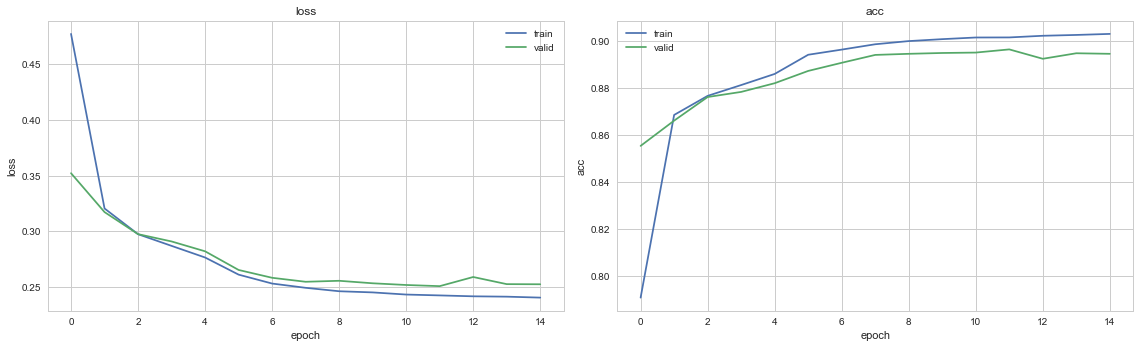

In [16]:
plot_history(history, figsize=(8, 5))

## Visualize the learned filters

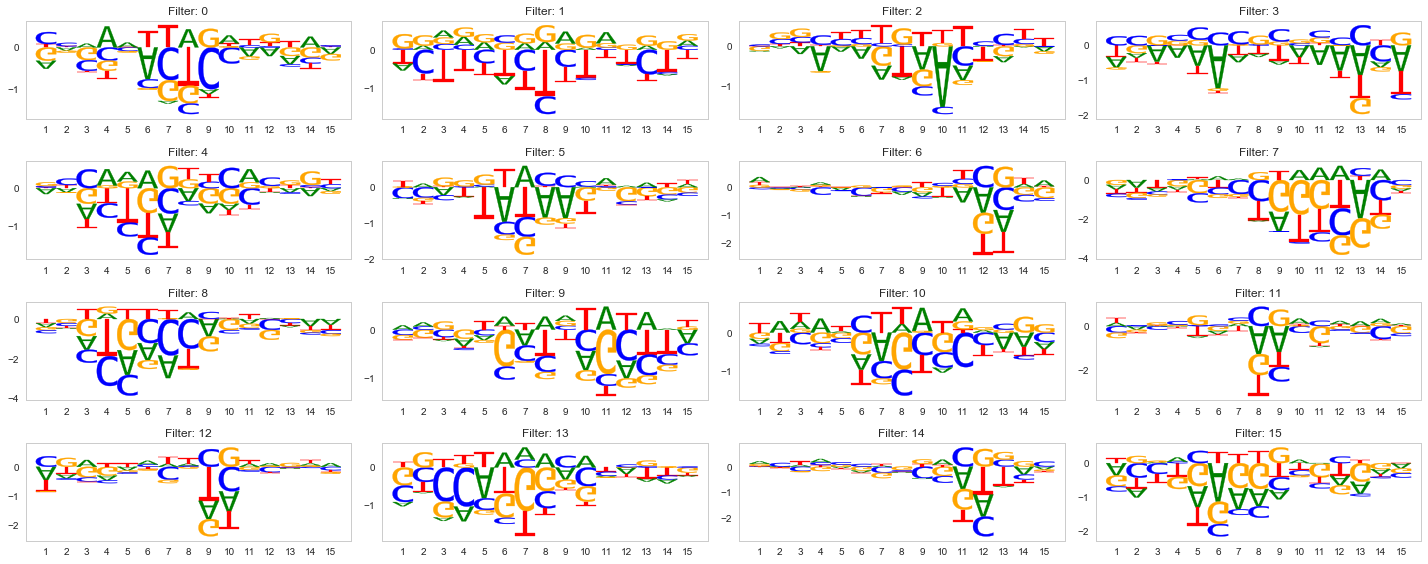

In [22]:
plot_filters(model.layers[0].get_weights()[0], 4, figsize=(20,8))

### Visualize the importance scores

As you can see, the filters are difficult to be interepreted directly. An popular approach for interepretation of black-box models like neural networks are feature importance scores.
Here, we will implement a gradient-based importance score called input masked gradients or sometimes also (wrongly) called saliency maps.



In [23]:
seq_pos = x_test[y_test==1]
seq_neg = x_test[y_test==0]

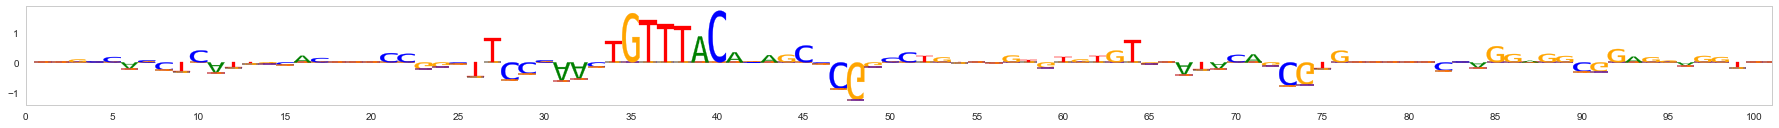

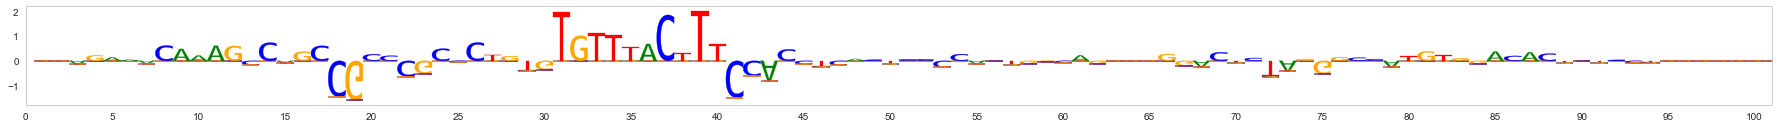

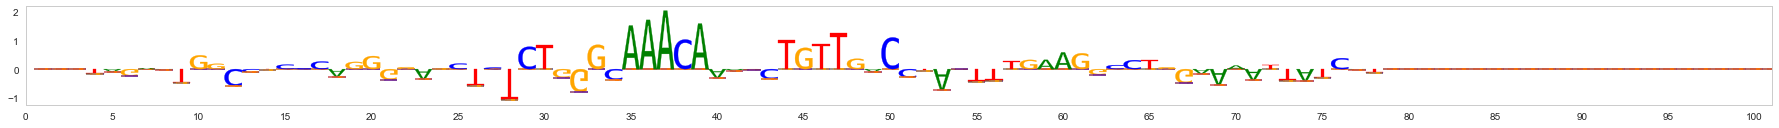

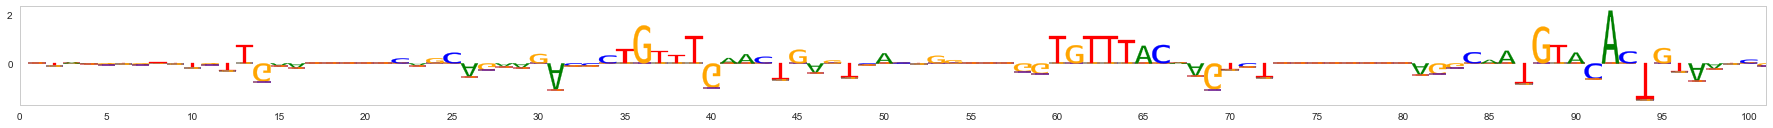

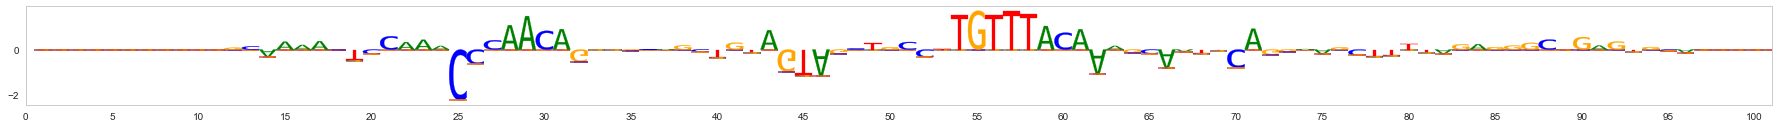

In [26]:
plot_seq_importance(model, seq_pos[:5], figsize=(25, 2))

As you can see, the CCANCTG motif clearly pops up. How does it look for the negative sequences?

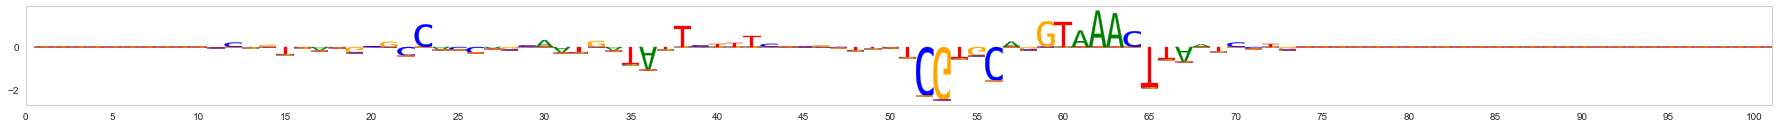

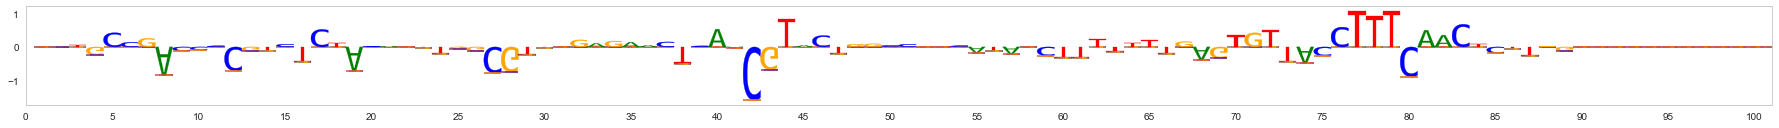

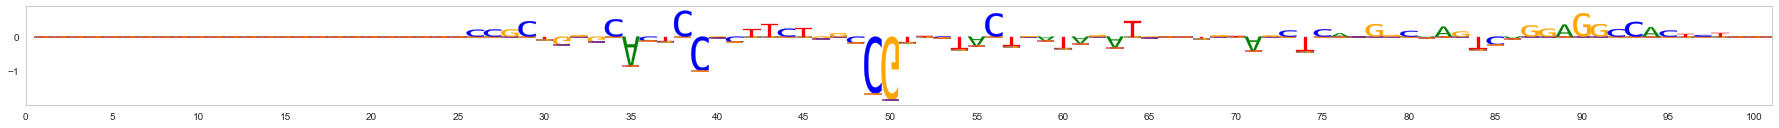

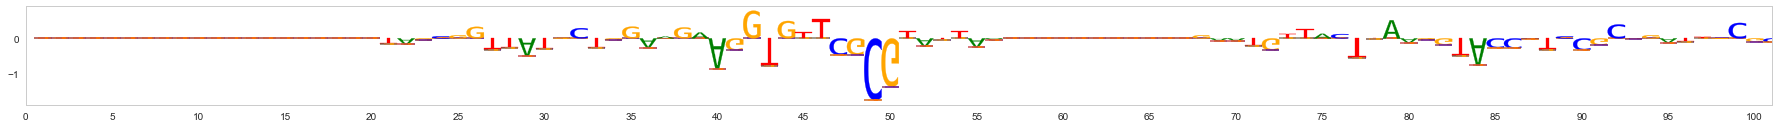

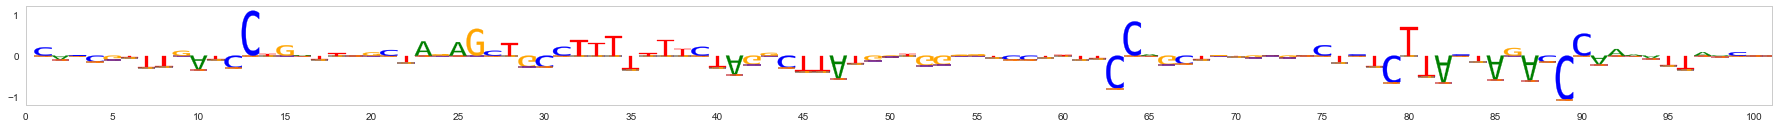

In [27]:
plot_seq_importance(model, seq_neg[:5], figsize=(25, 2))

There doesn't seem to be as strong as for the positive examples.